Fetching environmental data for Jakarta...
Environmental data fetched for Jakarta
Environmental data: {
  "location": "Jakarta",
  "temperature": 30.19,
  "humidity": 69.0,
  "sunlight_hours": 4.5,
  "air_quality_index": 105,
  "air_quality": "Poor"
}
Preparing training data...
Created synthetic training dataset with 1000 examples

Sample data:


,temperature,humidity,sunlight_hours,water_freq_days,indoor_placement,soil_type,air_quality,plant_type
0,33.322844,69.017818,5.708449,7,away_from_window,sandy,Moderate,Succulent
1,15.078385,49.740344,6.439479,1,window_sill,chalky,Moderate,Succulent
2,21.820834,53.487256,9.253633,3,near_window,clay,Poor,Flowering
3,7.851696,45.726778,7.935184,14,away_from_window,sandy,Poor,Succulent
4,11.014071,50.582640,4.912139,1,near_window,peaty,Moderate,Flowering



Distribution of plant types:
plant_type
Succulent        482
Flowering        186
Fern             172
Herb              80
Air Purifying     45
Tropical          35
Name: count, dtype: int64


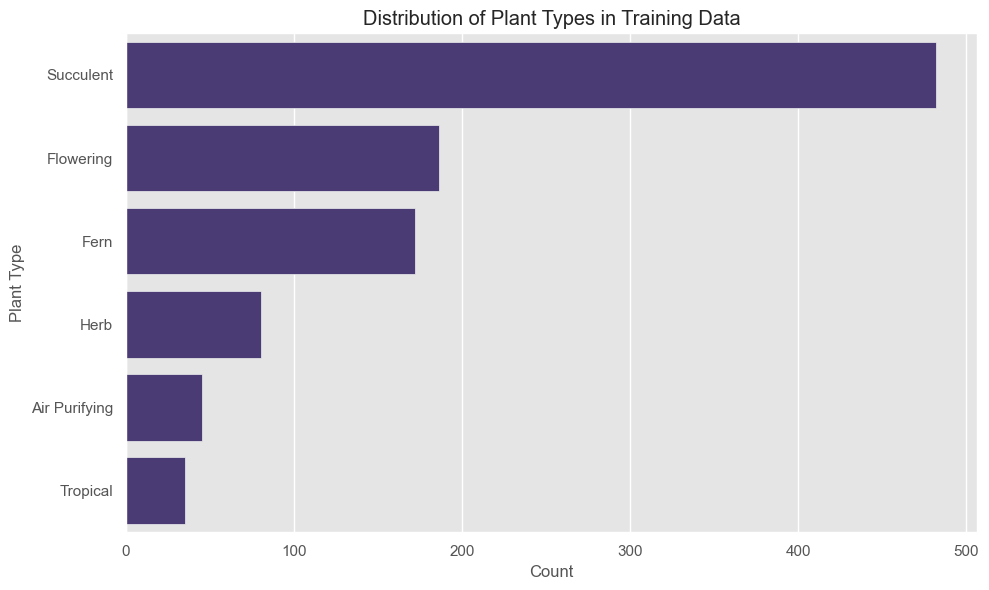

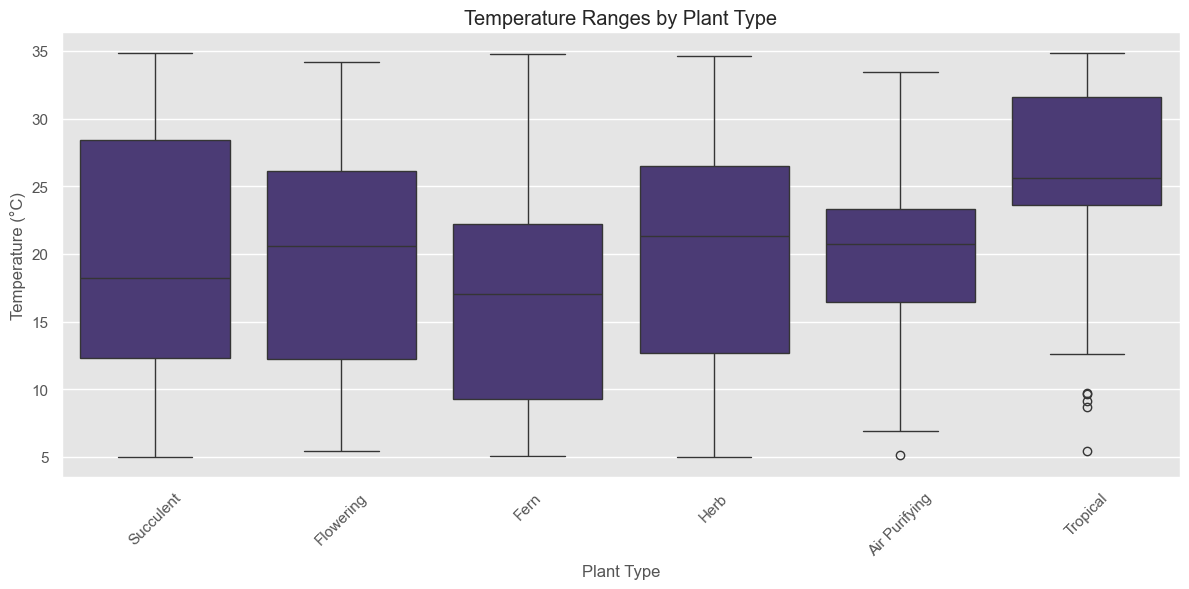

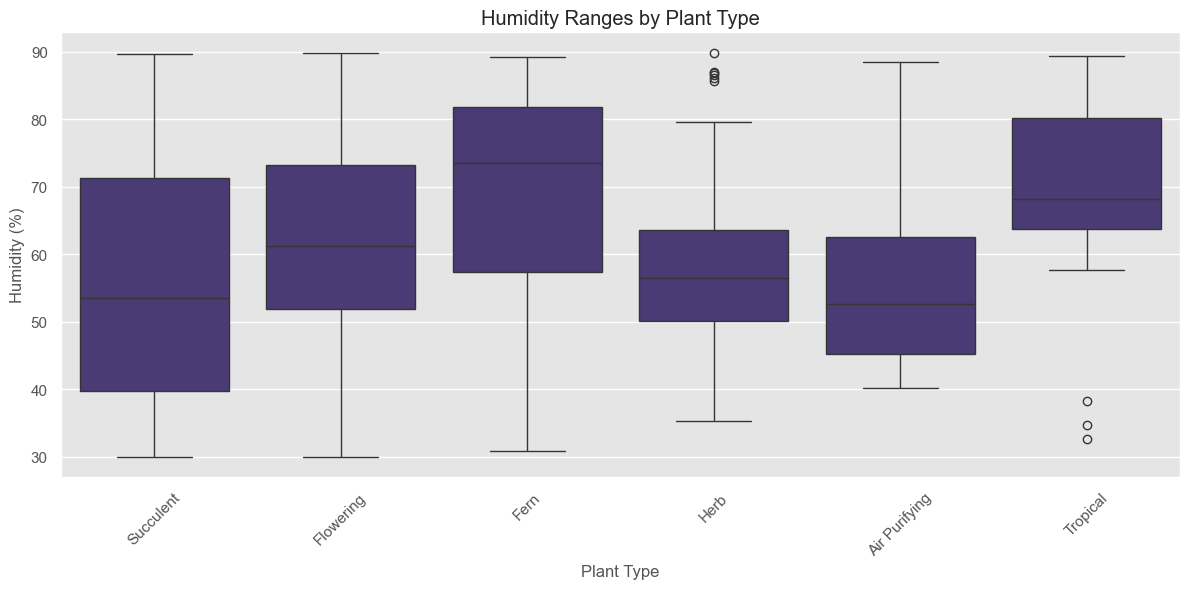

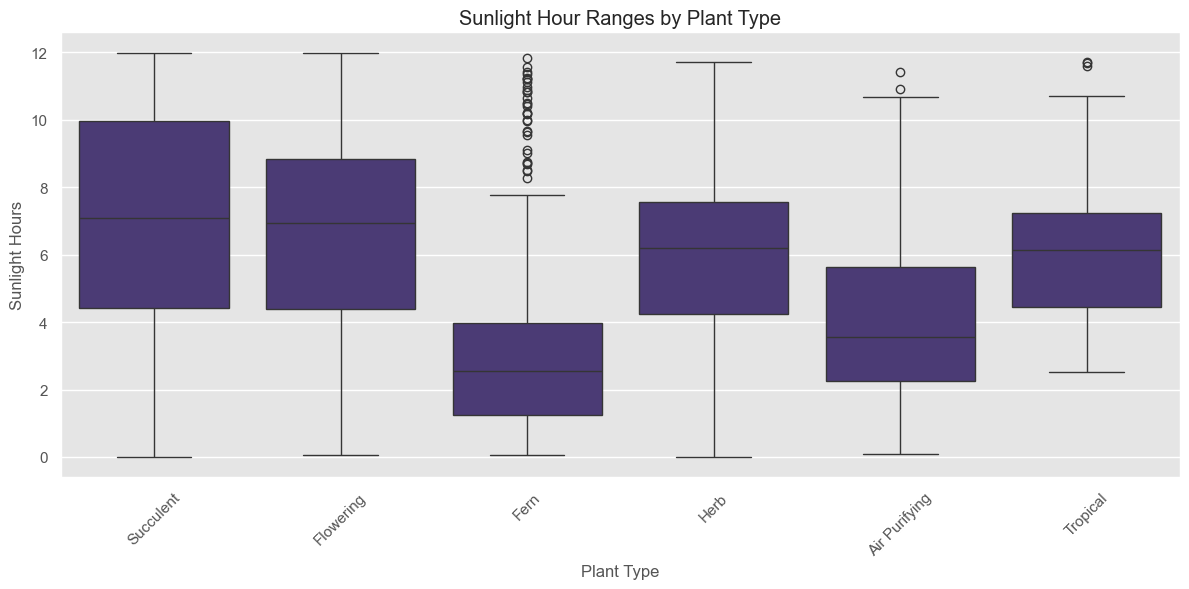

Training plant recommendation model...
Model accuracy: 79.00%

Classification Report:
               precision    recall  f1-score   support

Air Purifying       0.67      0.50      0.57         4
         Fern       0.77      0.81      0.79        37
    Flowering       0.71      0.66      0.68        38
         Herb       0.75      0.53      0.62        17
    Succulent       0.83      0.94      0.88        98
     Tropical       0.00      0.00      0.00         6

     accuracy                           0.79       200
    macro avg       0.62      0.57      0.59       200
 weighted avg       0.76      0.79      0.77       200



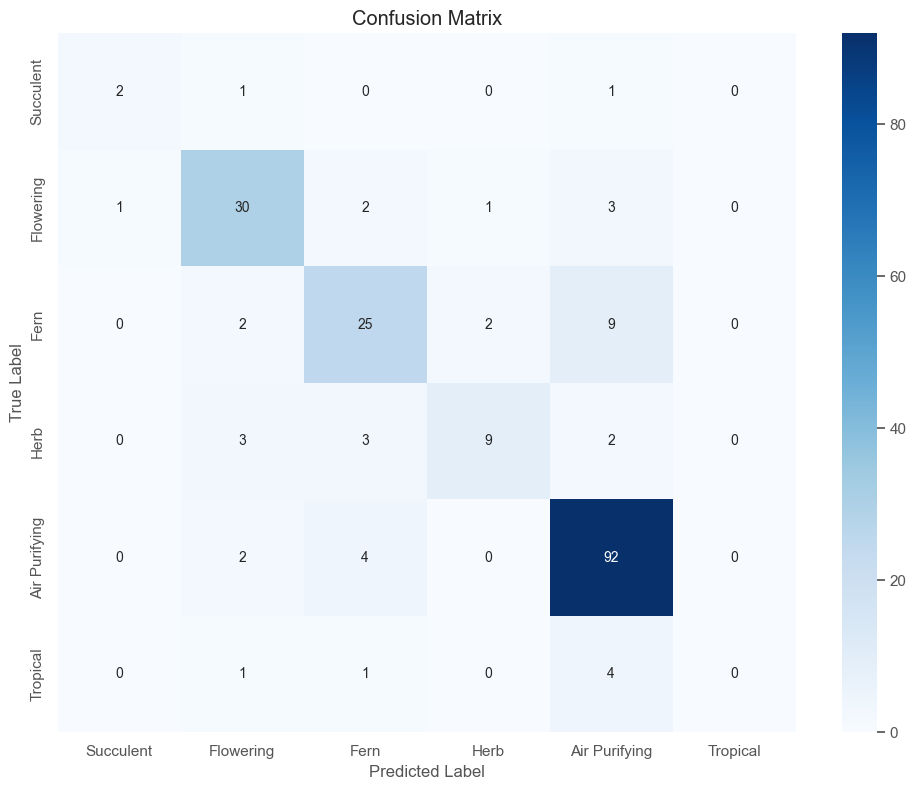

Saving model to disk...
Model saved to plant_recommendation_model.pkl
Fetching environmental data for London...
Environmental data fetched for London

Recommendations for Jakarta:
{
  "environmental_analysis": {
    "location": "London",
    "temperature": 5.98,
    "humidity": 84.0,
    "sunlight_hours": 4.5,
    "air_quality_index": 101,
    "air_quality": "Poor"
  },
  "indoor_conditions": {
    "indoor_placement": "window_sill",
    "water_freq_days": 3,
    "soil_type": "loamy"
  },
  "model_accuracy": 79.0,
  "plant_recommendations": [
    {
      "plant_type": "Air Purifying",
      "confidence": 63.0
    },
    {
      "plant_type": "Fern",
      "confidence": 15.0
    },
    {
      "plant_type": "Flowering",
      "confidence": 11.0
    }
  ],
  "care_instructions": {
    "watering": "Most air-purifying plants prefer consistent moisture. Water when top inch of soil feels dry.",
    "light": "Tolerates low to medium light, but grows best in bright, indirect light.",
    "soil"

In [55]:
# AI Green: Plant Recommendation System
# 
# This notebook demonstrates and implements the machine learning model for plant recommendations
# based on environmental conditions and user preferences.

# ## 1. Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import os
import datetime
import warnings
import joblib

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Suppress warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('ggplot')
sns.set_palette("viridis")

# Display settings for Pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

# ## 2. Define API Keys

# API Keys for data fetching
OPENWEATHER_API_KEY = 'c9478deddab23f12cca794d50c8e7897'

# ## 3. Data Fetching Functions

def fetch_weather(location):
    """ Fetch weather data from OpenWeather API """
    url = f'http://api.openweathermap.org/data/2.5/weather?q={location}&appid={OPENWEATHER_API_KEY}&units=metric'
    response = requests.get(url)
    
    if response.status_code != 200:
        print(f"Error fetching weather data: {response.status_code}")
        print(f"Response: {response.text}")
        return pd.DataFrame()
        
    data = response.json()
    weather = {
        'location': location,
        'temperature': data['main']['temp'],
        'humidity': data['main']['humidity']
    }
    return pd.DataFrame([weather])

def fetch_environmental_data(location):
    """Fetch real environmental data for a given location"""
    print(f"Fetching environmental data for {location}...")
    
    # Get weather data from OpenWeather API
    weather_df = fetch_weather(location)
    
    if weather_df.empty:
        print(f"Could not fetch weather data for {location}")
        return None
    
    # Extract data from the DataFrame
    weather_data = {
        'location': location,
        'temperature': float(weather_df['temperature'].iloc[0]),
        'humidity': float(weather_df['humidity'].iloc[0])
    }
    
    # Add estimated sunlight hours based on location and season
    latitude_data = {
        'London': 51.5,
        'New York': 40.7,
        'Tokyo': 35.7,
        'Sydney': -33.9,
        'Paris': 48.9,
        'Berlin': 52.5,
        'Los Angeles': 34.0,
        'Chicago': 41.9,
        'Toronto': 43.7,
        'Beijing': 39.9,
        'Delhi': 28.6,
        'Mumbai': 19.1
    }
    
    # Default latitude if location not found
    latitude = latitude_data.get(location, 40.0)
    
    # Estimate sunlight hours based on latitude and current month
    current_month = datetime.datetime.now().month
    
    # Northern hemisphere: more sun in summer, less in winter
    # Southern hemisphere: opposite
    if latitude > 0:  # Northern hemisphere
        sunlight_factor = 1.0 + 0.5 * np.sin((current_month - 6) * np.pi / 6)
    else:  # Southern hemisphere
        sunlight_factor = 1.0 + 0.5 * np.sin((current_month) * np.pi / 6)
    
    # Base sunlight hours (between 4 and 12)
    base_hours = 8.0
    weather_data['sunlight_hours'] = round(base_hours * sunlight_factor, 1)
    
    # Estimate air quality (mock data for demo)
    air_quality_index = np.random.randint(30, 150)
    weather_data['air_quality_index'] = air_quality_index
    
    if air_quality_index < 50:
        air_quality = 'Good'
    elif air_quality_index < 100:
        air_quality = 'Moderate'
    else:
        air_quality = 'Poor'
    
    weather_data['air_quality'] = air_quality
    
    print(f"Environmental data fetched for {location}")
    return weather_data

# ## 4. Test Environmental Data Fetching

# Test with a sample location
test_location = "Jakarta"
environmental_data = fetch_environmental_data(test_location)
print("Environmental data:", json.dumps(environmental_data, indent=2))

# ## 5. Prepare Training Data

def prepare_training_data(sample_size=500):
    """Create and prepare training data for the model"""
    print("Preparing training data...")
    
    # This would normally come from a database, but we'll create synthetic data for the hackathon
    # Features: temperature, humidity, sunlight_hours, water_needs, indoor_placement
    data = {
        'temperature': np.random.uniform(5, 35, sample_size),  # Range 5°C to 35°C
        'humidity': np.random.uniform(30, 90, sample_size),    # Range 30% to 90%
        'sunlight_hours': np.random.uniform(0, 12, sample_size),  # Range 0 to 12 hours
        'water_freq_days': np.random.choice([1, 2, 3, 7, 14], sample_size),  # Water frequency in days
        'indoor_placement': np.random.choice(['window_sill', 'near_window', 'away_from_window', 'balcony'], sample_size),
        'soil_type': np.random.choice(['sandy', 'loamy', 'clay', 'peaty', 'chalky'], sample_size),
        'air_quality': np.random.choice(['Good', 'Moderate', 'Poor'], sample_size)
    }
    
    # Plant types with optimal growing conditions
    plant_conditions = {
        'Succulent': {
            'temp_range': (10, 35),
            'humidity_range': (20, 50),
            'sunlight_range': (4, 12),
            'water_freq': [7, 14],
            'indoor_placement': ['window_sill', 'near_window'],
            'soil_type': ['sandy', 'loamy'],
            'air_quality': ['Good', 'Moderate', 'Poor']  # Succulents are resilient
        },
        'Fern': {
            'temp_range': (15, 25),
            'humidity_range': (60, 90),
            'sunlight_range': (0, 4),
            'water_freq': [1, 2, 3],
            'indoor_placement': ['near_window', 'away_from_window'],
            'soil_type': ['peaty', 'loamy'],
            'air_quality': ['Good', 'Moderate']  # Ferns prefer cleaner air
        },
        'Herb': {
            'temp_range': (15, 30),
            'humidity_range': (40, 70),
            'sunlight_range': (4, 8),
            'water_freq': [2, 3],
            'indoor_placement': ['window_sill', 'balcony'],
            'soil_type': ['loamy', 'sandy'],
            'air_quality': ['Good', 'Moderate']
        },
        'Flowering': {
            'temp_range': (15, 30),
            'humidity_range': (40, 80),
            'sunlight_range': (3, 10),
            'water_freq': [2, 3, 7],
            'indoor_placement': ['window_sill', 'near_window', 'balcony'],
            'soil_type': ['loamy', 'peaty'],
            'air_quality': ['Good', 'Moderate']
        },
        'Tropical': {
            'temp_range': (20, 35),
            'humidity_range': (60, 90),
            'sunlight_range': (2, 8),
            'water_freq': [1, 2, 3],
            'indoor_placement': ['near_window', 'away_from_window'],
            'soil_type': ['peaty', 'loamy'],
            'air_quality': ['Good']  # Tropicals often prefer clean air
        },
        'Air Purifying': {
            'temp_range': (15, 30),
            'humidity_range': (40, 70),
            'sunlight_range': (2, 6),
            'water_freq': [3, 7],
            'indoor_placement': ['near_window', 'away_from_window'],
            'soil_type': ['loamy', 'peaty'],
            'air_quality': ['Moderate', 'Poor']  # These plants help clean the air
        }
    }
    
    # Determine the best plant type for each set of conditions
    plant_types = []
    for i in range(sample_size):
        temp = data['temperature'][i]
        humidity = data['humidity'][i]
        sun = data['sunlight_hours'][i]
        water = data['water_freq_days'][i]
        placement = data['indoor_placement'][i]
        soil = data['soil_type'][i]
        air = data['air_quality'][i]
        
        scores = {}
        
        for plant, conditions in plant_conditions.items():
            score = 0
            
            # Temperature match
            if conditions['temp_range'][0] <= temp <= conditions['temp_range'][1]:
                score += 1
            
            # Humidity match
            if conditions['humidity_range'][0] <= humidity <= conditions['humidity_range'][1]:
                score += 1
            
            # Sunlight match
            if conditions['sunlight_range'][0] <= sun <= conditions['sunlight_range'][1]:
                score += 1
            
            # Water frequency match
            if water in conditions['water_freq']:
                score += 1
            
            # Placement match
            if placement in conditions['indoor_placement']:
                score += 1
            
            # Soil type match
            if soil in conditions['soil_type']:
                score += 1
                
            # Air quality match
            if air in conditions['air_quality']:
                score += 1
            
            scores[plant] = score
        
        # Select the plant type with highest score
        best_plant = max(scores, key=scores.get)
        plant_types.append(best_plant)
    
    data['plant_type'] = plant_types
    
    # Convert to DataFrame
    df = pd.DataFrame(data)
    print(f"Created synthetic training dataset with {len(df)} examples")
    
    return df

# Generate training data with 1000 samples for better model performance
training_data = prepare_training_data(sample_size=1000)

# Display sample of the data
print("\nSample data:")
display(training_data.head())

# Display distribution of plant types
print("\nDistribution of plant types:")
plant_distribution = training_data['plant_type'].value_counts()
print(plant_distribution)

# Visualize plant type distribution
plt.figure(figsize=(10, 6))
sns.countplot(y=training_data['plant_type'], order=plant_distribution.index)
plt.title('Distribution of Plant Types in Training Data')
plt.xlabel('Count')
plt.ylabel('Plant Type')
plt.tight_layout()
plt.show()

# ## 6. Analyze Environmental Factors

# Analyze how temperature affects plant types
plt.figure(figsize=(12, 6))
sns.boxplot(x='plant_type', y='temperature', data=training_data)
plt.title('Temperature Ranges by Plant Type')
plt.xlabel('Plant Type')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Analyze how humidity affects plant types
plt.figure(figsize=(12, 6))
sns.boxplot(x='plant_type', y='humidity', data=training_data)
plt.title('Humidity Ranges by Plant Type')
plt.xlabel('Plant Type')
plt.ylabel('Humidity (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Analyze how sunlight hours affect plant types
plt.figure(figsize=(12, 6))
sns.boxplot(x='plant_type', y='sunlight_hours', data=training_data)
plt.title('Sunlight Hour Ranges by Plant Type')
plt.xlabel('Plant Type')
plt.ylabel('Sunlight Hours')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ## 7. Plant Recommendation Model Class

class PlantRecommendationModel:
    def __init__(self):
        """Initialize the plant recommendation model"""
        self.model = None
        self.features = None
        self.plant_types = None
        self.model_file = 'plant_recommendation_model.pkl'
        self.feature_file = 'model_features.pkl'
        self.plant_types_file = 'plant_types.pkl'
        self.accuracy = 0.0
    
    def train(self, data):
        """Train the model using provided data"""
        # Split features and target
        X = data.drop('plant_type', axis=1)
        y = data['plant_type']
        
        # Store feature names for later reference
        self.features = list(X.columns)
        self.plant_types = list(y.unique())
        
        # Split into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Define preprocessing for categorical features
        categorical_features = ['indoor_placement', 'soil_type', 'air_quality']
        categorical_transformer = OneHotEncoder(handle_unknown='ignore')
        
        # Define preprocessing for numerical features
        numerical_features = ['temperature', 'humidity', 'sunlight_hours', 'water_freq_days']
        numerical_transformer = StandardScaler()
        
        # Combine preprocessing steps
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numerical_transformer, numerical_features),
                ('cat', categorical_transformer, categorical_features)
            ])
        
        # Create and train the pipeline with a RandomForest classifier
        self.model = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
        ])
        
        print("Training plant recommendation model...")
        self.model.fit(X_train, y_train)
        
        # Evaluate the model
        self.accuracy = self.model.score(X_test, y_test)
        print(f"Model accuracy: {self.accuracy:.2%}")
        
        # Get predictions
        y_pred = self.model.predict(X_test)
        
        # Print classification report
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
        # Create confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        cm_df = pd.DataFrame(cm, index=self.plant_types, columns=self.plant_types)
        
        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()
        
        return self.accuracy
    
    def save_model(self):
        """Save the trained model and related information to disk"""
        if self.model is None:
            print("No trained model to save")
            return False
        
        print("Saving model to disk...")
        joblib.dump(self.model, self.model_file)
        joblib.dump(self.features, self.feature_file)
        joblib.dump(self.plant_types, self.plant_types_file)
        print(f"Model saved to {self.model_file}")
        return True
    
    def load_model(self):
        """Load a previously trained model from disk"""
        try:
            print("Loading model from disk...")
            self.model = joblib.load(self.model_file)
            self.features = joblib.load(self.feature_file)
            self.plant_types = joblib.load(self.plant_types_file)
            print("Model loaded successfully")
            return True
        except FileNotFoundError:
            print("No saved model found. Please train a model first.")
            return False
    
    def predict(self, conditions):
        """
        Predict the best plant types for given conditions
        
        Args:
            conditions (dict): Dictionary containing environmental and indoor conditions
                               Required keys: temperature, humidity, sunlight_hours, 
                                              water_freq_days, indoor_placement, soil_type
                               
        Returns:
            list: Top 3 recommended plant types with confidence scores
        """
        if self.model is None:
            print("No model loaded. Please train or load a model first.")
            return None
        
        try:
            # Create a copy of conditions to avoid modifying the original
            input_conditions = conditions.copy()
            
            # Ensure all required features are present
            for feature in self.features:
                if feature not in input_conditions:
                    if feature == 'water_freq_days':
                        # Assign a default value based on other conditions
                        if input_conditions.get('indoor_placement') == 'window_sill':
                            input_conditions[feature] = 3
                        else:
                            input_conditions[feature] = 7
                    elif feature == 'soil_type':
                        # Default to loamy which is versatile
                        input_conditions[feature] = 'loamy'
                    elif feature == 'air_quality':
                        # Default to Moderate if not specified
                        input_conditions[feature] = 'Moderate'
                    else:
                        print(f"Missing required feature: {feature}")
                        return None
            
            # Create a DataFrame from the conditions
            input_df = pd.DataFrame([input_conditions])
            
            # Get probability predictions for each class
            probabilities = self.model.predict_proba(input_df)[0]
            
            # Get top 3 plant types with their probabilities
            top_indices = probabilities.argsort()[-3:][::-1]
            recommendations = [
                {"plant_type": self.plant_types[i], "confidence": float(probabilities[i] * 100)} 
                for i in top_indices
            ]
            
            return recommendations
        
        except Exception as e:
            print(f"Error making prediction: {str(e)}")
            return None
    
    def generate_care_instructions(self, plant_type):
        """
        Generate care instructions for a given plant type
        
        Args:
            plant_type (str): The type of plant
            
        Returns:
            dict: Care instructions and growing timeline
        """
        care_instructions = {
            'Succulent': {
                'watering': 'Water sparingly, allowing soil to dry completely between waterings. Typically every 7-14 days.',
                'light': 'Bright, direct sunlight for at least 4-6 hours daily.',
                'soil': 'Well-draining, sandy soil. Cactus or succulent mix recommended.',
                'fertilizing': 'Feed with diluted succulent fertilizer once every 2-3 months during growing season.',
                'timeline': [
                    {'month': 1, 'action': 'Dormant period. Minimal watering needed.'},
                    {'month': 3, 'action': 'Beginning of growing season. Resume normal watering schedule.'},
                    {'month': 6, 'action': 'Active growth period. Can propagate from cuttings or leaves.'},
                    {'month': 9, 'action': 'Transition to dormancy. Reduce watering frequency.'}
                ]
            },
            'Fern': {
                'watering': 'Keep soil consistently moist but not soggy. Water when top inch of soil feels dry.',
                'light': 'Indirect or filtered light. Avoid direct sunlight which can burn leaves.',
                'soil': 'Rich, organic soil with good moisture retention. Peat-based potting mix ideal.',
                'fertilizing': 'Apply balanced liquid fertilizer monthly during growing season at half strength.',
                'timeline': [
                    {'month': 1, 'action': 'Winter maintenance. Keep away from cold drafts.'},
                    {'month': 3, 'action': 'Beginning of active growth. Increase humidity if possible.'},
                    {'month': 6, 'action': 'Check if repotting is needed. Division possible for crowded plants.'},
                    {'month': 9, 'action': 'Growth slows down. Reduce fertilizer application.'}
                ]
            },
            'Herb': {
                'watering': 'Water when top inch of soil is dry. Most herbs prefer soil on the drier side.',
                'light': 'Most herbs need 4-6 hours of direct sunlight daily.',
                'soil': 'Well-draining soil with moderate fertility. Avoid overly rich soils.',
                'fertilizing': 'Light application of balanced fertilizer every 4-6 weeks during growing season.',
                'timeline': [
                    {'month': 1, 'action': 'Indoor growing period. Supplement with grow lights if needed.'},
                    {'month': 3, 'action': 'Begin harvesting outer leaves as plants grow.'},
                    {'month': 6, 'action': 'Peak growing season. Regular harvesting encourages bushier growth.'},
                    {'month': 9, 'action': 'Harvest and preserve remaining herbs before winter dormancy.'}
                ]
            },
            'Flowering': {
                'watering': 'Keep soil evenly moist during blooming period. Check soil moisture regularly.',
                'light': 'Most flowering plants need at least 6 hours of direct sunlight daily.',
                'soil': 'Rich, well-draining soil with added compost or organic matter.',
                'fertilizing': 'Apply bloom-boosting fertilizer (higher phosphorus) every 2-4 weeks during flowering period.',
                'timeline': [
                    {'month': 1, 'action': 'Winter rest period for many flowering plants.'},
                    {'month': 3, 'action': 'Spring growth begins. Start deadheading spent blooms.'},
                    {'month': 6, 'action': 'Peak flowering period. Regular deadheading extends blooming.'},
                    {'month': 9, 'action': 'End of main blooming. Prepare plants for dormancy.'}
                ]
            },
            'Tropical': {
                'watering': 'Keep soil consistently moist but not waterlogged. Mist leaves regularly to increase humidity.',
                'light': 'Bright, indirect light. Protection from harsh afternoon sun.',
                'soil': 'Rich, well-draining potting mix with plenty of organic matter.',
                'fertilizing': 'Apply balanced liquid fertilizer every 2-4 weeks during growing season.',
                'timeline': [
                    {'month': 1, 'action': 'Winter maintenance. Keep away from cold drafts and maintain humidity.'},
                    {'month': 3, 'action': 'Beginning of growth cycle. Good time for repotting if needed.'},
                    {'month': 6, 'action': 'Active growth period. Monitor for pests in warmer weather.'},
                    {'month': 9, 'action': 'Growth slows. Reduce watering and fertilizing frequency.'}
                ]
            },
            'Air Purifying': {
                'watering': 'Most air-purifying plants prefer consistent moisture. Water when top inch of soil feels dry.',
                'light': 'Tolerates low to medium light, but grows best in bright, indirect light.',
                'soil': 'Well-draining potting mix with good moisture retention.',
                'fertilizing': 'Apply diluted balanced fertilizer every 4-6 weeks during growing season.',
                'timeline': [
                    {'month': 1, 'action': 'Indoor growing period. Clean leaves to maximize air purification.'},
                    {'month': 3, 'action': 'Spring growth begins. Good time for repotting if roots are crowded.'},
                    {'month': 6, 'action': 'Active growth period. Check for adequate space and air circulation.'},
                    {'month': 9, 'action': 'Growth slows. Reduce watering and fertilizing frequency.'}
                ]
            }
        }
        
        if plant_type in care_instructions:
            return care_instructions[plant_type]
        else:
            return {
                'watering': 'Water when top inch of soil feels dry.',
                'light': 'Medium light conditions, avoiding direct harsh sunlight.',
                'soil': 'General purpose potting mix with good drainage.',
                'fertilizing': 'Apply balanced fertilizer monthly during growing season.',
                'timeline': [
                    {'month': 3, 'action': 'Spring growth begins.'},
                    {'month': 6, 'action': 'Peak growing season.'},
                    {'month': 9, 'action': 'Growth slows down for fall/winter.'}
                ]
            }
            
    def analyze_and_recommend(self, location, indoor_conditions):
        """
        Complete analysis and recommendation based on location and indoor conditions
        
        Args:
            location (str): City name or location
            indoor_conditions (dict): User input about indoor growing environment
                                     Keys: indoor_placement, water_freq_days, soil_type
                                     
        Returns:
            dict: JSON-compatible dictionary with complete recommendations
        """
        # Fetch environmental data for the location
        env_data = fetch_environmental_data(location)
        
        if not env_data:
            return {"error": f"Could not fetch environmental data for {location}"}
        
        # Combine environmental and indoor conditions
        conditions = {**env_data}
        if indoor_conditions:
            conditions.update(indoor_conditions)
        
        # Ensure we have a model
        if not self.model:
            # Try to load, or train if needed
            if not self.load_model():
                self.train(training_data)
                self.save_model()
        
        # Get plant recommendations
        plant_recommendations = self.predict(conditions)
        
        if not plant_recommendations:
            return {"error": "Could not generate plant recommendations"}
        
        # Get care instructions for top recommendation
        top_plant = plant_recommendations[0]["plant_type"]
        care_instructions = self.generate_care_instructions(top_plant)
        
        # Prepare result in JSON format
        result = {
            "environmental_analysis": env_data,
            "indoor_conditions": indoor_conditions,
            "model_accuracy": round(float(self.accuracy * 100), 2),
            "plant_recommendations": plant_recommendations,
            "care_instructions": care_instructions
        }
        
        return result

# ## 8. Train and Evaluate Model

# Initialize model
model = PlantRecommendationModel()

# Train model with our prepared data
model.train(training_data)

# Save the model to disk
model.save_model()

# ## 9. Test the Recommendation System

# Test with London environmental data and specific indoor conditions
test_location = "London"
test_conditions = {
    "indoor_placement": "window_sill",
    "water_freq_days": 3,
    "soil_type": "loamy"
}

# Generate recommendations
london_recommendations = model.analyze_and_recommend(test_location, test_conditions)

# Print the recommendations in JSON format
print("\nRecommendations for Jakarta:")
print(json.dumps(london_recommendations, indent=2))

# Save recommendations to JSON file
with open('jakarta_recommendations.json', 'w') as f:
    json.dump(london_recommendations, f, indent=2)
print("\nRecommendations saved to london_recommendations.json")

# ## 10. Visualize Recommendations

# Function to visualize recommendations
def visualize_recommendations(recommendations, title):
    """Create visualizations for plant recommendations"""
    if "error" in recommendations:
        print(f"Error: {recommendations['error']}")
        return
    
    # Extract plant recommendations
    plants = [rec["plant_type"] for rec in recommendations["plant_recommendations"]]
    confidences = [rec["confidence"] for rec in recommendations["plant_recommendations"]]
    
    # Confidence bar chart
    plt.figure(figsize=(10, 5))
    bars = plt.bar(plants, confidences, color=sns.color_palette("viridis", len(plants)))
    
    # Add data labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                 f'{height:.1f}%', ha='center', va='bottom')
    
    plt.title(f'Plant Recommendations for {title}')
    plt.xlabel('Plant Type')
    plt.ylabel('Confidence (%)')
    plt.ylim(0, 100)  # Set y-axis limit to 100%
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Care instructions visualization for top plant
    top_plant = recommendations["plant_recommendations"][0]["plant_type"]
    care = recommendations["care_instructions"]
    
    # Create a figure for care instructions
    plt.figure(figsize=(12, 8))
    plt.text(0.5, 0.95, f'Care Instructions for {top_plant}', 
             horizontalalignment='center', fontsize=16, fontweight='bold')
    
    # Watering
    plt.text(0.5, 0.85, f'Watering:', fontsize=14, fontweight='bold')
    plt.text(0.5, 0.8, care['watering'], horizontalalignment='center', wrap=True)
    
    # Light
    plt.text(0.5, 0.7, f'Light:', fontsize=14, fontweight='bold')
    plt.text(0.5, 0.65, care['light'], horizontalalignment='center', wrap=True)
    
    # Soil
    plt.text(0.5, 0.55, f'Soil:', fontsize=14, fontweight='bold')
    plt.text(0.5, 0.5, care['soil'], horizontalalignment='center', wrap=True)
    
    # Fertilizing
    plt.text(0.5, 0.4, f'Fertilizing:', fontsize=14, fontweight='bold')
    plt.text(0.5, 0.35, care['fertilizing'], horizontalalignment='center', wrap=True)
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Timeline visualization
    plt.figure(figsize=(14, 6))
    plt.title(f'Growing Timeline for {top_plant}', fontsize=16)
    
    months = [item['month'] for item in care['timeline']]
    actions = [item['action'] for item in care['timeline']]
    
    # Plot timeline
    for i, (month, action) in enumerate(zip(months, actions)):
        plt.plot([month, month], [0, 1], 'k-', alpha=0.3)
        plt.scatter(month, 0.5, s=120, c='#3498db')
        plt.annotate(f'Month {month}:\\n{action}', 
                    xy=(month, 0.5), xytext=(month, 0.7 if i % 2 == 0 else 0.3),
                    ha='center', va='center',
                    bbox=dict(boxstyle='round,pad=0.5', fc='#f9f9f9', alpha=0.8),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2'))
    
    plt.xlim(0, 13)  # Full year
    plt.ylim(0, 1)
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.yticks([])
    plt.tight_layout()
    plt.show()